# Centralized Learning to Federated Learning

COGONI Guillaume (p1810070)

# Import libraries

In [75]:
# Torch
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim import Adam, lr_scheduler
import torch.nn as nn

# Time
import time

# Random
import random

# Tqdm
from tqdm import tqdm
from tqdm import trange

# Copy
import copy

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

# Pandas
import pandas as pd

# Datetime
from datetime import datetime, timedelta

# Matplotlib
import matplotlib.pyplot as plt

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importation of the dataset

In [77]:
dataset = pd.read_csv("./202207-divvy-tripdata.csv") # Replace by your dataset

In [78]:
data = dataset.copy() # Copy

# Visiualisation

In [79]:
# Print columns, dtypes and the 3 first observation
print(data.columns)
print(data.dtypes)
data.head(3)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'ride_length', 'day_of_week'],
      dtype='object')
ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
ride_length            object
day_of_week             int64
dtype: object


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week
0,7EA7A3AEAAB5F621,classic_bike,7/1/2022 0:00,7/1/2022 0:11,Sheffield Ave & Wellington Ave,TA1307000052,Sheffield Ave & Waveland Ave,TA1307000126,41.936253,-87.652662,41.949399,-87.654529,casual,0:11:05,6
1,AAB8184C169FF64E,electric_bike,7/1/2022 0:00,7/1/2022 0:41,NaN,NaN,NaN,NaN,41.930000,-87.640000,41.930000,-87.640000,casual,0:41:25,6
2,C60D39A2484F33FB,electric_bike,7/1/2022 0:00,7/1/2022 0:07,Sheffield Ave & Willow St,TA1306000032,Sedgwick St & Schiller St,TA1307000143,41.913730,-87.652776,41.907626,-87.638566,member,0:07:22,6


In [80]:
# Check if there is missing values and how many values are in the dataset
print(data.isna().sum().sort_values(ascending=False))
#print("---------------------------------------------")
#print(data.count().sort_values(ascending=True))

end_station_name      120951
end_station_id        120951
start_station_name    112031
start_station_id      112031
end_lat                  947
end_lng                  947
ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_lat                  0
start_lng                  0
member_casual              0
ride_length                0
day_of_week                0
dtype: int64


# Cleaning the Data

In [81]:
'''
@Param value: a string value with this format "Hour(s):Minute(s):Second(s)" 
'''
def convert_to_seconds(value):
    if not any(char.isdigit() for char in value):
        return pd.NaT
    hour, minute, second = map(int, value.split(':'))
    if hour >= 15:
        hour = 0
    if minute >= 60:
        minute = 0
        hour += 1
    if second >= 60:
        second = 0
        minute += 1
    return hour*3600+minute*60+second

data_prep = data.copy()

# Convert the Series "ride_length" to second
data_prep["ride_length"] = data_prep["ride_length"].apply(convert_to_seconds)

# dropNaN
data_prep = data_prep.dropna()

In [82]:
# Check if there is missing values and how many values are in the dataset
print(data_prep.isna().sum().sort_values(ascending=False))
print("---------------------------------------------")
print(data_prep.count().sort_values(ascending=False))

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
ride_length           0
day_of_week           0
dtype: int64
---------------------------------------------
ride_id               642666
rideable_type         642666
started_at            642666
ended_at              642666
start_station_name    642666
start_station_id      642666
end_station_name      642666
end_station_id        642666
start_lat             642666
start_lng             642666
end_lat               642666
end_lng               642666
member_casual         642666
ride_length           642666
day_of_week           642666
dtype: int64


In [83]:
# Check if ride_length correctly change
data_prep['ride_length'].sort_values(ascending=False)

393742    53998
310446    53971
154978    53960
366777    53854
32965     53619
          ...  
323524        0
199178        0
755309        0
75668         0
185955        0
Name: ride_length, Length: 642666, dtype: object

In [84]:
data_prep['ride_length'] = data_prep['ride_length'].astype('int64')
print(data.shape)
data_prep.dtypes

(823488, 15)


ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
ride_length             int64
day_of_week             int64
dtype: object

# Selection of the features and the target

In [85]:
features = ['start_lat', 
            'start_lng',
            'end_lat',
            'end_lng',
            'member_casual',
            'ride_length',
            'day_of_week',
            'ride_id']
            
target = ["rideable_type"]

In [86]:
data_prep = data_prep.loc[(data_prep["rideable_type"] == "classic_bike") | (data_prep["rideable_type"] == "electric_bike")]
X = data_prep[features]
y = data_prep[target]

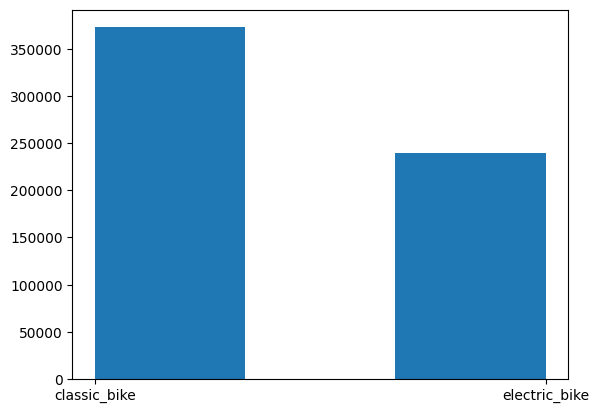

In [87]:
plt.hist(y, bins=3)
plt.show()

In [88]:
print("Information on X (shape and dtype)")
print(X.shape)
print(X.dtypes)
print("\n")
print("Information on y (shape and dtype)")
print(y.shape)
print(y.dtypes)

Information on X (shape and dtype)
(612067, 8)
start_lat        float64
start_lng        float64
end_lat          float64
end_lng          float64
member_casual     object
ride_length        int64
day_of_week        int64
ride_id           object
dtype: object


Information on y (shape and dtype)
(612067, 1)
rideable_type    object
dtype: object


# Preprocessing on the data 

In [89]:
y_OH = OneHotEncoder(handle_unknown='ignore', sparse=False).fit_transform(y)

num_cols = ["start_lat", "start_lng", "end_lat", "end_lng", "day_of_week", "ride_length"]
categorical_cols_less_values = ["member_casual"]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat_less_values', OrdinalEncoder(), categorical_cols_less_values)
    ])

X_prep = preprocessor.fit_transform(X)

c:\Users\gcogoni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Creation of the dataset

In [90]:
X_tensor = torch.tensor(X_prep, dtype=torch.float32)
y_tensor = torch.tensor(y_OH, dtype=torch.float32)

In [91]:
print(X.shape)
print(X_prep.shape)
print(X_tensor.shape)

print(y_OH.shape)
print(y_tensor.shape)

(612067, 8)
(612067, 7)
torch.Size([612067, 7])
(612067, 2)
torch.Size([612067, 2])


In [92]:
dataset_tensor = torch.utils.data.TensorDataset(X_tensor, y_tensor)

In [93]:
len(dataset_tensor)

612067

#Models

In [94]:
class MyNet(nn.Module):
    def __init__(self, _Input, _Output):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(_Input, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, _Output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Centralized Version

## Separation of the data (train and validation)

In [95]:
train_size = int(0.6 * len(dataset_tensor))
val_size = len(dataset_tensor) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset_tensor, [train_size, val_size])

In [96]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3200, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=3200, shuffle=True)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes= {'train': len(train_dataset), 'val': len(val_dataset)}

# Train and Test function

In [97]:
def train_and_test_nn(model, criterion, optimizer, dataloaders, batch_size, num_epochs=25):

    since = time.time()
    # Instantiate the neural network and the optimizer
    model = model
    optimizer = optimizer
    criterion = criterion
    best_acc_avg = 0.0

    #pbar = trange(num_epochs, unit="carrots")

    # Train the neural network
    for epoch in range(num_epochs):
        print("\n")
        print("_________________________Epoch %d / %d ____________________" % (epoch+1, num_epochs))
        print("\n")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            correct = 0
            precision = 0.0
            recall = 0.0
            i = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item()
                    correct += torch.sum(preds == torch.argmax(labels,1))
                    precision += precision_score(torch.argmax(labels,1), preds)
                    recall += recall_score(torch.argmax(labels,1), preds)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                i+=1
            
            ##Statistics

            # Calculate the average loss
            loss_avg = running_loss / (i+1)

            # Calculate the average accuracy
            accuracy_avg = correct.double() / dataset_sizes[phase]

            # Calculate the average precision and recall
            precision_avg = precision / (i+1)

            # Calculate the average recall
            recall_avg = recall / (i+1)


            # Print the average loss, accuracy, precision, recall for once for train and val per epoch
            print('PHASE %s:  [AVG loss: %.3f || AVG Accuracy: %.4f] [AVG Precision: %.3f || AVG Recall: %.3f]' % 
                  (phase, loss_avg, accuracy_avg, precision_avg, recall_avg))
            

            # deep copy the model
            if phase == 'val' and accuracy_avg > best_acc_avg:
                best_acc_avg = accuracy_avg
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print("\n")
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc_avg))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Starting training and validation

In [98]:
model = MyNet(X_tensor.shape[1], y_tensor.shape[1])
epochs = 20
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

#model_ft = train_and_test_nn(model, criterion, optimizer_ft, dataloaders, 1, num_epochs=10)

# Federated Version

In [99]:
global_model = MyNet(X_tensor.shape[1], y_tensor.shape[1])
local_model = MyNet(X_tensor.shape[1], y_tensor.shape[1])

In [175]:
def params_models_equals(model_1,model_2):
    """_summary_

    Args:
        model_1 (_type_): a neural network pythorch
        model_2 (_type_): a neural network pytorch
    """
    
    # Vérifier si les deux modèles ont les mêmes paramètres
    params_1 = model_1.state_dict()
    params_2 = model_2.state_dict()

    equal = all([torch.allclose(params_1[key], params_2[key]) for key in params_1.keys()])

    if equal:
        print("The models have the same parameters.")
    else:
        print("The models have differents parameters.")

## Creation Nodes

In [178]:
node_1_data, node_2_data, node_3_data, node_4_data, _ = torch.utils.data.random_split(dataset_tensor, [10000, 10000, 10000, 10000, len(dataset_tensor) - 40000])

### Splitting node_i_data into train_data and val_data

In [179]:
nodes = {
        'node_1': {'model': copy.deepcopy(local_model), 'data': node_1_data},
        'node_2': {'model': copy.deepcopy(local_model), 'data': node_2_data},
        'node_3': {'model': copy.deepcopy(local_model), 'data': node_3_data},
        'node_4': {'model': copy.deepcopy(local_model), 'data': node_4_data}
}

In [180]:
def split_data_nodes(nodes):
    """_summary_

    Args:
        nodes (_type_): dictionnary of nodes 
        {
            model: #, 
            data : #
        }

    Returns:
        _type_: a new dictionnary of nodes with a new format 
        {
            model: #, 
            data : 
            {
                train_data: #,
                val_data: #
            }
        }
    """
    for node in nodes.keys():
        train_data, val_data = torch.utils.data.random_split(nodes[node]['data'], [0.5, 0.5])
        print(train_data)
        nodes[node]['data'] = {'train_data': train_data, 'val_data': val_data}
    return nodes

In [181]:
nodes = split_data_nodes(nodes)

In [182]:
for node in nodes.keys():
    print(node)
    print(nodes[node]['data'])

node_1
{'train_data': <torch.utils.data.dataset.Subset object at 0x00000133C41E8040>, 'val_data': <torch.utils.data.dataset.Subset object at 0x00000133C41E9D50>}
node_2
{'train_data': <torch.utils.data.dataset.Subset object at 0x00000133D409B880>, 'val_data': <torch.utils.data.dataset.Subset object at 0x00000133D409A560>}
node_3
{'train_data': <torch.utils.data.dataset.Subset object at 0x00000133D409A6B0>, 'val_data': <torch.utils.data.dataset.Subset object at 0x00000133D409A4D0>}
node_4
{'train_data': <torch.utils.data.dataset.Subset object at 0x00000133D409B940>, 'val_data': <torch.utils.data.dataset.Subset object at 0x00000133B1F573D0>}


### Copying global model parameters into local model of nodes

In [183]:
for node in nodes.keys():
  params_models_equals(nodes[node]['model'], global_model)

The models have differents parameters.
The models have differents parameters.
The models have differents parameters.
The models have differents parameters.


In [184]:
def send_global_model_to_node(global_model, node):    
        node['model'].load_state_dict(copy.deepcopy(global_model.state_dict()))
        return node

In [185]:
# We send the main model to the nodes. 
for node in nodes.keys():
    nodes[node] = send_global_model_to_node(global_model, nodes[node])

In [186]:
for node in nodes.keys():
  params_models_equals(nodes[node]['model'], global_model)

The models have the same parameters.
The models have the same parameters.
The models have the same parameters.
The models have the same parameters.


In [195]:
def train_and_test_node(node, criterion, optimizer, batch_size_train, batch_size_test, num_epochs=25):
    train_loader = torch.utils.data.DataLoader(node['data']['train_data'], batch_size=batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(node['data']['val_data'], batch_size=batch_size_test, shuffle=True)

    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes= {'train': len(node['data']['train_data']), 'val': len(node['data']['train_data'])}

    since = time.time()
    # Instantiate the neural network and the optimizer
    model = node['model']
    optimizer = optimizer
    criterion = criterion
    best_acc_avg = 0.0

    #pbar = trange(num_epochs, unit="carrots")

    # Train the neural network
    for epoch in range(num_epochs):
        print("\n")
        print("_________________________Epoch %d / %d ____________________" % (epoch+1, num_epochs))
        print("\n")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            correct = 0
            precision = 0.0
            recall = 0.0
            i = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item()
                    correct += torch.sum(preds == torch.argmax(labels,1))
                    precision += precision_score(torch.argmax(labels,1), preds)
                    recall += recall_score(torch.argmax(labels,1), preds)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                i+=1
            
            ##Statistics

            # Calculate the average loss
            loss_avg = running_loss / (i+1)

            # Calculate the average accuracy
            accuracy_avg = correct.double() / dataset_sizes[phase]

            # Calculate the average precision and recall
            precision_avg = precision / (i+1)

            # Calculate the average recall
            recall_avg = recall / (i+1)


            # Print the average loss, accuracy, precision, recall for once for train and val per epoch
            print('PHASE %s:  [AVG loss: %.3f || AVG Accuracy: %.4f] [AVG Precision: %.3f || AVG Recall: %.3f]' % 
                (phase, loss_avg, accuracy_avg, precision_avg, recall_avg))
            

            # deep copy the model
            if phase == 'val' and accuracy_avg > best_acc_avg:
                best_acc_avg = accuracy_avg
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print("\n")
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc_avg))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return {'model': model, 'node_best_acc_avg': best_acc_avg}


In [197]:
nodes_best_avg = {}

for node in nodes:
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(nodes[node]['model'].parameters(), lr=0.001)
    model_best_acc_avg = train_and_test_node(nodes[node], criterion, optimizer, 100, 100, num_epochs=50)
    nodes[node]['model'] = model_best_acc_avg['model']
    nodes_best_avg[node] = model_best_acc_avg['node_best_acc_avg']
print(nodes_best_avg)



_________________________Epoch 1 / 50 ____________________


PHASE train:  [AVG loss: 0.512 || AVG Accuracy: 0.7398] [AVG Precision: 0.729 || AVG Recall: 0.501]
PHASE val:  [AVG loss: 0.609 || AVG Accuracy: 0.6780] [AVG Precision: 0.601 || AVG Recall: 0.444]


_________________________Epoch 2 / 50 ____________________


PHASE train:  [AVG loss: 0.509 || AVG Accuracy: 0.7450] [AVG Precision: 0.730 || AVG Recall: 0.508]
PHASE val:  [AVG loss: 0.606 || AVG Accuracy: 0.6738] [AVG Precision: 0.583 || AVG Recall: 0.479]


_________________________Epoch 3 / 50 ____________________


PHASE train:  [AVG loss: 0.511 || AVG Accuracy: 0.7428] [AVG Precision: 0.726 || AVG Recall: 0.510]
PHASE val:  [AVG loss: 0.604 || AVG Accuracy: 0.6886] [AVG Precision: 0.643 || AVG Recall: 0.408]


_________________________Epoch 4 / 50 ____________________


PHASE train:  [AVG loss: 0.511 || AVG Accuracy: 0.7414] [AVG Precision: 0.717 || AVG Recall: 0.514]
PHASE val:  [AVG loss: 0.607 || AVG Accuracy: 0.6870] 